# ライブラリ

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn import preprocessing
import os

# データ読み込み

In [42]:
df = pd.read_csv('./data_all.csv')
df.head()

,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,...,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀,愛知県豊田市千石町7-2,40000
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,...,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人,大阪府吹田市千里万博公園5-2,21000
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,...,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也,広島県広島市安佐南区大塚西5-1-1,50000
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,...,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,北海道札幌市豊平区羊ヶ丘1,39232


# データ分析

In [43]:
# columns確認
df.columns

Index(['id', 'y', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away',
       'stadium', 'tv', 'home_score', 'away_score', 'weather', 'temperature',
       'humidity', 'referee', 'home_team', 'home_01', 'home_02', 'home_03',
       'home_04', 'home_05', 'home_06', 'home_07', 'home_08', 'home_09',
       'home_10', 'home_11', 'away_team', 'away_01', 'away_02', 'away_03',
       'away_04', 'away_05', 'away_06', 'away_07', 'away_08', 'away_09',
       'away_10', 'away_11', 'address', 'capa'],
      dtype='object')

In [44]:
# サイズ確認
df.shape

(1953, 43)

In [45]:
# 欠損値確認
df.isnull().sum()

id             0
y              0
year           0
stage          0
match          0
gameday        0
time           0
home           0
away           0
stadium        0
tv             0
home_score     0
away_score     0
weather        0
temperature    0
humidity       0
referee        0
home_team      0
home_01        0
home_02        0
home_03        0
home_04        0
home_05        0
home_06        0
home_07        0
home_08        0
home_09        0
home_10        0
home_11        0
away_team      0
away_01        0
away_02        0
away_03        0
away_04        0
away_05        0
away_06        0
away_07        0
away_08        0
away_09        0
away_10        0
away_11        0
address        0
capa           0
dtype: int64

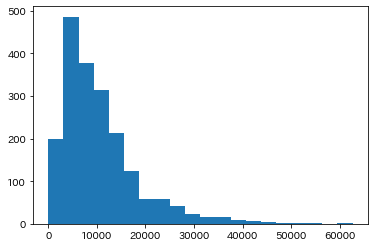

In [46]:
# 目的変数の分布
plt.hist(df['y'], bins=20)
plt.show()

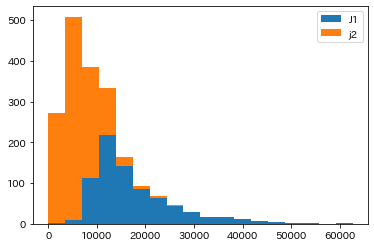

In [47]:
# 目的変数の分布（J1、J2別）
j1_df = df[df['stage'] == 'Ｊ１']
j2_df = df[df['stage'] == 'Ｊ２']
labels = ['J1', 'j2']
plt.hist([j1_df['y'], j2_df['y']], histtype='barstacked', bins=18, label=labels)
plt.legend()

J1とJ2で分布が全く異なる。

# 数値化  
・year：そのまま  
・stage：J1→0、J2→1  
・match：第○節かどうか抜き出す  
・gameday：monthとdayを抽出  
・time：hour部分だけ抽出  
・home,away,stadium：マッピング  
・tv：NHK総合を含む(0)、NHKを含む(1)、BSを含む(2)、その他(3)とする。tv_countも抽出  
・weather：雨or雪を含む(0)、その他(1)、晴を含む(2)、屋内を含む(3)  
・temperature：そのまま  
・humidity：○％のみ抽出  
・capa：そのまま  
・home_score,away_score：そのまま  
・home_team,away_team：マッピング  
・home_01〜home_11,away_01〜away_11：マッピング  
・address：都道府県のみマッピング

In [48]:
def preprocessing_1(df):
    df_mapping = df
    #match 第○節かどうか抜き出す
    df_mapping['match'] = df['match'].apply(lambda x: x[1:].rsplit('節',1)[0])
    
    # gameday monthとdayを抽出
    df_mapping['day'] = df['gameday'].apply(lambda x: x[:-1].rsplit('(',1)[-1])
    
    # dayを月(0)〜日(6)でマッピング
    day_mapping = {'月':0, '火':1, '水':2, '木':3, '金':4, '土':5, '日':6}
    df_mapping['day'] = df['day'].map(day_mapping)
    df_mapping['day'] = df['day'].fillna(7) # 欠損は7(祝日)として埋める
    df_mapping['month'] = df['gameday'].apply(lambda x: x[:2])
    
    # time hour部分だけ抽出
    df_mapping['time'] = df['time'].apply(lambda x: x.split(':', 1)[0])
    
    # tv NHK総合(0)、NHK(1)、BS(2)、その他(3)
    # tv数も抽出(tv_count)
    for i in range(len(df)):
        df_mapping.loc[i, 'tv_count'] = df.loc[i, 'tv'].count('／')+1
        if 'ＮＨＫ総合' in df.loc[i, 'tv']:
            df_mapping.loc[i, 'tv'] = 0
        elif 'ＮＨＫ' in df.loc[i, 'tv']:
            df_mapping.loc[i, 'tv'] = 1
        elif 'ＢＳ' in df.loc[i,'tv']:
            df_mapping.loc[i, 'tv'] = 1
        else:
            df_mapping.loc[i, 'tv'] = 2
            
    # weather 雨or雪(0)、晴(2)、屋内(3)、その他(1)
    for i in range(len(df)):
        if '雨' in df.loc[i, 'weather']:
            df_mapping.loc[i, 'weather'] = 0
        elif '雪' in df.loc[i, 'weather']:
            df_mapping.loc[i, 'weather'] = 0
        elif  '晴' in df.loc[i, 'weather']:
            df_mapping.loc[i, 'weather'] = 2
        elif  '屋内' in df.loc[i, 'weather']:
            df_mapping.loc[i, 'weather'] = 3
        else:
            df_mapping.loc[i, 'weather'] = 1
            
    #humidity → 〇％のみ抽出
    df_mapping['humidity'] = df['humidity'].apply(lambda x: x[:-1].rsplit('%', 1)[-1])
    
    #address → 都道府県でマッピング
    df_mapping['address'] = df['address'].apply(lambda x: x[:2])
    
    #home_01~home_11,away_01~away_11 → マッピング
    #home,away,stadium → マッピング
    for column in ['home','stage','away','stadium','referee', 'home_01', 'home_02', 'home_03',
           'home_04', 'home_05', 'home_06', 'home_07', 'home_08', 'home_09',
           'home_10', 'home_11', 'away_01', 'away_02', 'away_03',
           'away_04', 'away_05', 'away_06', 'away_07', 'away_08', 'away_09',
           'away_10', 'away_11','address']:
        le = preprocessing.LabelEncoder()
        le.fit(df_mapping[column])
        df_mapping[column] = le.transform(df_mapping[column])
    
    #数値でない変数、いらない変数の削除
    df_mapping = df_mapping.drop(['id', 'gameday','home_team', 'away_team'],axis=1)
    return df_mapping

In [49]:
df_1 = preprocessing_1(df)
df_1.head()

,y,year,stage,match,time,home,away,stadium,tv,home_score,...,away_07,away_08,away_09,away_10,away_11,address,capa,day,month,tv_count
0,18250,2012,0,１,14,16,38,15,0,1,...,110,162,204,136,31,8,19694,5.0,03,4.0
1,24316,2012,0,１,14,22,36,48,1,1,...,237,231,389,0,122,17,40000,5.0,03,4.0
2,17066,2012,0,１,14,5,20,17,1,2,...,252,360,251,231,121,7,21000,5.0,03,4.0
3,29603,2012,0,１,14,9,35,3,1,1,...,160,240,226,117,230,14,50000,5.0,03,4.0
4,25353,2012,0,１,14,7,13,36,1,0,...,155,175,219,310,105,3,39232,5.0,03,4.0


In [50]:
y = pd.DataFrame(df_1, columns=['y'])
y.head()

,y
0,18250
1,24316
2,17066
3,29603
4,25353


In [51]:
x = df_1.drop('y', axis=1)
x.head()

,year,stage,match,time,home,away,stadium,tv,home_score,away_score,...,away_07,away_08,away_09,away_10,away_11,address,capa,day,month,tv_count
0,2012,0,１,14,16,38,15,0,1,0,...,110,162,204,136,31,8,19694,5.0,03,4.0
1,2012,0,１,14,22,36,48,1,1,0,...,237,231,389,0,122,17,40000,5.0,03,4.0
2,2012,0,１,14,5,20,17,1,2,3,...,252,360,251,231,121,7,21000,5.0,03,4.0
3,2012,0,１,14,9,35,3,1,1,0,...,160,240,226,117,230,14,50000,5.0,03,4.0
4,2012,0,１,14,7,13,36,1,0,0,...,155,175,219,310,105,3,39232,5.0,03,4.0


In [52]:
def linear_regression(x,y):
    global lr,model_quad_2,model_cubic_3,quad,cubic
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    ##1次回帰
    # 重回帰の線形回帰を実行
    lr = LinearRegression()
    #ホールドアウト法で分割
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
    # 重回帰線形モデルの学習
    lr.fit(x_train, y_train)

    ##２次回帰
    # 2次関数の変数
    from sklearn.preprocessing import PolynomialFeatures
    quad = PolynomialFeatures(degree=2)
    # 生成した基底関数で変数変換を実行
    x_quad = quad.fit_transform(x)
    # ホールドアウト法で分割
    x_quad_train, x_quad_test,y_quad_train, y_quad_test = train_test_split(x_quad, y, test_size = 0.3, random_state = 0)
    # 線形回帰による学習
    model_quad_2 = LinearRegression()
    model_quad_2.fit(x_quad_train, y_quad_train)

    ##3次回帰
    # 3次関数の変数変換
    cubic = PolynomialFeatures(degree=3)
    # 生成した基底関数で変数変換を実行
    x_cubic = cubic.fit_transform(x)
    # ホールドアウト法で分割
    x_cubic_train, x_cubic_test,y_cubic_train, y_cubic_test = train_test_split(x_cubic, y, test_size = 0.3, random_state = 0)
    # 線形回帰による学習
    model_cubic_3 = LinearRegression()
    model_cubic_3.fit(x_cubic_train, y_cubic_train)
    
    ## 自由度調整済み決定係数
    # (決定係数, trainまたはtestのサンプル数, 利用した特徴量の数)
    def adjusted(score, n_sample, n_features):
        adjusted_score = 1 - (1 - score) * ((n_sample - 1) / (n_sample - n_features - 1))
        return adjusted_score
    print('[自由度調整済み決定係数]')
    #1次関数
    print('1次')
    print('train: %3f' % adjusted(lr.score(x_train, y_train), len(y_train), 2))
    print('test : %3f' % adjusted(lr.score(x_test, y_test), len(y_test), 2))
    # 2次関数
    print('2次')
    print('train: %.3f' % adjusted(model_quad_2.score(x_quad_train, y_quad_train), len(y_quad_train), 3))
    print('test : %.3f' % adjusted(model_quad_2.score(x_quad_test, y_quad_test), len(y_quad_test), 3))
    # 3次関数
    print('3次')
    print('train: %.3f' % adjusted(model_cubic_3.score(x_cubic_train, y_cubic_train), len(y_cubic_train), 3))
    print('test : %.3f' % adjusted(model_cubic_3.score(x_cubic_test, y_cubic_test), len(y_cubic_test), 3))
    print('')
    
    #RMSE
    #MSEを出力する関数を読み込む
    from sklearn.metrics import mean_squared_error as mse
    print('[RMSE]')
    #1次関数
    print('1次')
    print('train: %.3f' % (mse(y_train, lr.predict(x_train)) ** (1/2)))
    print('test : %.3f' % (mse(y_test, lr.predict(x_test)) ** (1/2)))
    #2次関数
    print('2次')
    print('train: %.3f' % (mse(y_quad_train, model_quad_2.predict(x_quad_train)) ** (1/2)))
    print('test : %.3f' % (mse(y_quad_test, model_quad_2.predict(x_quad_test)) ** (1/2)))
    #3次関数
    print('3次')
    print('train: %.3f' % (mse(y_cubic_train, model_cubic_3.predict(x_cubic_train)) ** (1/2)))
    print('test : %.3f' % (mse(y_cubic_test, model_cubic_3.predict(x_cubic_test)) ** (1/2)))

In [53]:
linear_regression(x,y)

[自由度調整済み決定係数]
1次
train: 0.701478
test : 0.644583
2次
train: 0.940
test : 0.347
3次
train: 1.000
test : 0.014

[RMSE]
1次
train: 4478.459
test : 4666.784
2次
train: 2005.777
test : 6320.068
3次
train: 0.000
test : 7767.472


In [54]:
def submit(model,test_df,x_test):
    y_pred=model.predict(x_test).reshape(-1)
    submit_file = pd.DataFrame({'id' : test_df['id'], 'y' : y_pred})
    submit_file.to_csv('submit.csv', index = False, header = False)

In [55]:
test_df= pd.read_csv('test_new.csv')
test_df_1 = preprocessing_1(test_df)
submit(lr,test_df,test_df_1)

# 改善  
①意味のないマッピングデータを意味のあるものにしていくor削除していく  
・選手名→日本代表の数  
・チーム→順位を代入  
・ホームチーム→ホームでの平均観客数を使用  
・レフェリー→削除  
②処理の改善  
ただの重回帰分析だったので、多数の変数を処理できるLGBMを試す。  
③その他  
数値の標準化、外れ値の処理

In [56]:
#代表リストを作る
daihyo_df = pd.read_csv('daihyo.csv')
daihyo_df.head()
#初出場と最終出場が2012-2014の間の選手のみ抽出
daihyo_df["初出場"] = daihyo_df["初出場"].apply(lambda x: int(x[:4]))
daihyo_df["最終出場"] = daihyo_df["最終出場"].apply(lambda x: int(x[:4]))
daihyo_df_1 = daihyo_df[daihyo_df.初出場 < 2014]
daihyo_df_1 = daihyo_df_1[daihyo_df.最終出場 > 2012]
daihyo_df_1.index = np.arange(len(daihyo_df_1))
daihyo_df_1.head()
#df→リストにする
daihyo_list = daihyo_df_1["選手名"].values.tolist()

/var/folders/41/791kfl912mbb2ndn2ly5_y240000gn/T/ipykernel_51094/1238669280.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  daihyo_df_1 = daihyo_df_1[daihyo_df.最終出場 > 2012]


In [57]:
#homeとawayそれぞれチームと順位を合わせたDataFrameを作る。
team_df = pd.read_csv('team_1.csv')
home_df = team_df.loc[:,["順位","チーム","年","ステージ"]]
home_df.columns =["home_rank","home","year","stage"]
away_df = team_df.loc[:,["順位","チーム","年","ステージ"]]
away_df.columns =["away_rank","away","year","stage"]
home_df.head()

,home_rank,home,year,stage
0,1,ガンバ大阪,2014,Ｊ１
1,2,浦和レッズ,2014,Ｊ１
2,3,鹿島アントラーズ,2014,Ｊ１
3,4,柏レイソル,2014,Ｊ１
4,5,サガン鳥栖,2014,Ｊ１


In [58]:
#平均観客数のDataFrameを作成
attendance_df = pd.read_csv('attendance.csv')
attendance_df.columns =["home","year","attendance"]
attendance_df.head()

,home,year,attendance
0,コンサドーレ札幌,2011,10482.0
1,ベガルタ仙台,2011,15656.0
2,モンテディオ山形,2011,9325.0
3,鹿島アントラーズ,2011,16156.0
4,浦和レッズ,2011,33910.0


In [59]:
def preprocessing_2(df):
    df_2 = df
    #名字と名前の間の空白をなくす
    for i in range(1,12):
        df_2["home_{:02}".format(i)] = df_2["home_{:02}".format(i)].apply(lambda x: x.replace("　",""))
        df_2["away_{:02}".format(i)] = df_2["away_{:02}".format(i)].apply(lambda x: x.replace("　",""))
    #home_01~11,away01~11→True,False
    for i in range(len(df_2)):
        for j in range(1,12):
            df_2.loc[i,"home_{:02}".format(j)] = df_2.loc[i,"home_{:02}".format(j)] in daihyo_list
            df_2.loc[i,"away_{:02}".format(j)] = df_2.loc[i,"away_{:02}".format(j)] in daihyo_list
    #daihyo
    df_2["daihyo"] = (df_2==True).sum(axis=1)
    #home_rank,away_rank,difference
    df_2 = pd.merge(df_2,home_df,on=["home","year","stage"],how="left")
    df_2 = pd.merge(df_2,away_df,on=["away","year","stage"],how="left")
    df_2["difference"] = abs(df_2["home_rank"]-df_2["away_rank"])
    #attendanece
    df_2 = pd.merge(df_2,attendance_df,on=["home","year"],how="left")
    #year → そのまま
    #match → 第〇説かどうかのみ抜き出す
    df_2['match'] = df_2['match'].apply(lambda x: int(x[1:].rsplit('節', 1)[0]))
    #gameday → 月(month)と曜日(day)を抽出
    #       → 曜日(day)を月(0),火(1),水(2),木(3),金(4),土(5),日(6),祝休(7)でマッピング
    df_2['day'] = df_2['gameday'].apply(lambda x: x[:-1].rsplit('(', 1)[-1])
    day_mapping = {'月':0, '火':1, '水':2, '木':3,'金':4,'土':5,'日':6}
    df_2['day'] = df_2['day'].map(day_mapping)
    df_2['day'] = df_2["day"].fillna(7)
    df_2['month'] = df_2['gameday'].apply(lambda x: int(x[:2]))
    #time → 〇時(hour)の部分だけ抽出
    df_2['time'] = df_2['time'].apply(lambda x: int(x.split(':', 1)[0]))
    #tv → 'NHK総合'を含む(0),'NHK'を含む(1),'BS'を含む(2),その他(3)とする
    #   → tvの数も抽出(tv_count)
    for i in range(len(df_2)):
        df_2.loc[i,"tv_count"] = int(df_2.loc[i,"tv"].count("／") + 1)
        if 'ＮＨＫ総合' in df_2.loc[i,'tv']:
            df_2.loc[i,'tv']=0
        elif 'ＮＨＫ' in df_2.loc[i,'tv']:
            df_2.loc[i,'tv']=1
        elif  'ＢＳ' in df_2.loc[i,'tv']:
            df_2.loc[i,'tv']=1
        else:
            df_2.loc[i,'tv']=2
    #weather → "雨"もしくは"雪"を含む(0),"晴"を含む(2),'屋内'を含む(3),その他(1)とする
    for i in range(len(df_2)):
        if '雨' in df_2.loc[i,'weather']:
            df_2.loc[i,'weather']=0
        elif '雪' in df_2.loc[i,'weather']:
            df_2.loc[i,'weather']=0
        elif  '晴' in df_2.loc[i,'weather']:
            df_2.loc[i,'weather']=2
        elif  '屋内' in df_2.loc[i,'weather']:
            df_2.loc[i,'weather']=3
        else:
            df_2.loc[i,'weather']=1
    #temperature → そのまま
    #humidity → 〇％のみ抽出
    df_2['humidity'] = df_2['humidity'].apply(lambda x: int(x[:-1].rsplit('%', 1)[-1]))
    #capa → そのまま
    #address → 都道府県でマッピング
    df_2['address'] = df_2['address'].apply(lambda x: x[:2])
    #stadium,stage → マッピング
    for column in ['stage','stadium','address']:
        le = preprocessing.LabelEncoder()
        le.fit(df_2[column])
        df_2[column] = le.transform(df_2[column])
    #もう使わない変数、数値じゃない変数を削除
    df_2 = df_2.drop( ['id', 'gameday', 'home', 'away', 'referee', 'home_team', 'home_01', 'home_02', 'home_03', 'home_04',
       'home_05', 'home_06', 'home_07', 'home_08', 'home_09', 'home_10',
       'home_11','away_team', 'away_01', 'away_02', 'away_03', 'away_04', 'away_05',
       'away_06', 'away_07', 'away_08', 'away_09', 'away_10', 'away_11'],axis=1)
    return(df_2)

In [60]:
df= pd.read_csv('data_all.csv')
df_2 = preprocessing_2(df)
df_2.head()

,y,year,stage,match,time,stadium,tv,home_score,away_score,weather,...,address,capa,daihyo,home_rank,away_rank,difference,attendance,day,month,tv_count
0,18250,2012,0,1,14,15,0,1,0,0,...,8,19694,2,2,11,9,16600.0,5.0,3,4.0
1,24316,2012,0,1,14,48,1,1,0,3,...,17,40000,2,7,9,2,17155.0,5.0,3,4.0
2,17066,2012,0,1,14,17,1,2,3,0,...,7,21000,4,17,16,1,14778.0,5.0,3,4.0
3,29603,2012,0,1,14,3,1,1,0,0,...,14,50000,9,1,3,2,17721.0,5.0,3,4.0
4,25353,2012,0,1,14,36,1,0,0,3,...,3,39232,3,18,12,6,12008.0,5.0,3,4.0


In [61]:
#外れ値処理
for i in range(len(df_2)):
    if df_2.loc[i,'y'] == 0 or df_2.loc[i,'y'] >= 50000:
        df_2 = df_2.drop(i,axis=0)
        print(i)
df_2.index = np.arange(len(df_2))

270
693
942
1385
1463
1844


In [62]:
y = pd.DataFrame(df_2, columns=['y'])
x = df_2.drop('y',axis=1)

In [63]:
#標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_std = ss.fit_transform(x)

In [64]:
linear_regression(x_std,y)

[自由度調整済み決定係数]
1次
train: 0.821111
test : 0.808060
2次
train: 0.889
test : 0.798
3次
train: 1.000
test : -0.331

[RMSE]
1次
train: 3294.140
test : 3395.203
2次
train: 2588.330
test : 3476.868
3次
train: 0.000
test : 8933.118


In [65]:
# Lasso回帰
def lasso(x,y):
    global model_lasso_1,model_lasso_2,model_lasso_3
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    # データを学習させる（１次）
    model_lasso_1= Lasso(alpha=1000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
    model_lasso_1.fit(x_train, y_train)
    # データを学習させる（２次）
    model_lasso_2= Lasso(alpha=1000)
    quad = PolynomialFeatures(degree=2)
    x_quad = quad.fit_transform(x)
    x_quad_train, x_quad_test,y_quad_train, y_quad_test = train_test_split(x_quad, y, test_size = 0.3, random_state = 0)
    model_lasso_2.fit(x_quad_train,y_quad_train)
    # データを学習させる（３次）
    model_lasso_3= Lasso(alpha=1000)
    cubic = PolynomialFeatures(degree=3)
    x_cubic = cubic.fit_transform(x)
    x_cubic_train, x_cubic_test,y_cubic_train, y_cubic_test = train_test_split(x_cubic, y, test_size = 0.3, random_state = 0)
    model_lasso_3.fit(x_cubic_train,y_cubic_train)
    
    # 自由度調整済み決定係数
    # (決定係数, trainまたはtestのサンプル数, 利用した特徴量の数)
    def adjusted(score, n_sample, n_features):
        adjusted_score = 1 - (1 - score) * ((n_sample - 1) / (n_sample - n_features - 1))
        return adjusted_score
    print('[自由度調整済み決定係数]')
    #1次関数
    print('1次')
    print('train: %3f' % adjusted(model_lasso_1.score(x_train, y_train), len(y_train), 2))
    print('test : %3f' % adjusted(model_lasso_1.score(x_test, y_test), len(y_test), 2))
    # 2次関数
    print('2次')
    print('train: %.3f' % adjusted(model_lasso_2.score(x_quad_train, y_quad_train), len(y_quad_train), 3))
    print('test : %.3f' % adjusted(model_lasso_2.score(x_quad_test, y_quad_test), len(y_quad_test), 3))
    # 3次関数
    print('3次')
    print('train: %.3f' % adjusted(model_lasso_3.score(x_cubic_train, y_cubic_train), len(y_cubic_train), 3))
    print('test : %.3f' % adjusted(model_lasso_3.score(x_cubic_test, y_cubic_test), len(y_cubic_test), 3))
    print('')

    # MSEを出力する関数を読み込む
    from sklearn.metrics import mean_squared_error as mse
    print('[RMSE]')
    #1次関数
    print('1次')
    print('train: %.3f' % (mse(y_train, model_lasso_1.predict(x_train)) ** (1/2)))
    print('test : %.3f' % (mse(y_test, model_lasso_1.predict(x_test)) ** (1/2)))
    #2次関数
    print('2次')
    print('train: %.3f' % (mse(y_quad_train, model_lasso_2.predict(x_quad_train)) ** (1/2)))
    print('test : %.3f' % (mse(y_quad_test, model_lasso_2.predict(x_quad_test)) ** (1/2)))
    #3次関数
    print('3次')
    print('train: %.3f' % (mse(y_cubic_train, model_lasso_3.predict(x_cubic_train)) ** (1/2)))
    print('test : %.3f' % (mse(y_cubic_test, model_lasso_3.predict(x_cubic_test)) ** (1/2)))

In [66]:
lasso(x_std,y)

[自由度調整済み決定係数]
1次
train: 0.765399
test : 0.768272
2次
train: 0.769
test : 0.766
3次
train: 0.773
test : 0.760

[RMSE]
1次
train: 3772.374
test : 3730.539
2次
train: 3740.765
test : 3744.285
3次
train: 3709.695
test : 3791.137


In [67]:
# LightGBM
def lgbm(x,y):
    global model
    import lightgbm as lgb
    from sklearn.model_selection import train_test_split
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
    lgb_train = lgb.Dataset(x_train,y_train)
    lgb_eval = lgb.Dataset(x_test,y_test,reference=lgb_train)
    lgbm_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves':10,
        'num_boost_round':100,
        'verbose_eval':5,
        'max_depth':0
        }
    model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval)
    # RMSE を計算する
    from sklearn.metrics import mean_squared_error as mse
    print('train : %.3f' % (mse(y_train, model.predict(x_train)) ** (1/2)))
    print('test : %.3f' % (mse(y_test, model.predict(x_test)) ** (1/2)))

In [68]:
lgbm(x_std,y)

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 1362, number of used features: 21
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Start training from score 10524.246696
[1]	valid_0's rmse: 7133.45
[2]	valid_0's rmse: 6584.91
[3]	valid_0's rmse: 6122.17
[4]	valid_0's rmse: 5688.62
[5]	valid_0's rmse: 5333.13
[6]	valid_0's rmse: 5018.74
[7]	valid_0's rmse: 4760.25
[8]	valid_0's rmse: 4538.65
[9]	valid_0's rmse: 4357.86
[10]	valid_0's rmse: 4206.72
[11]	valid_0's rmse: 4073.25
[12]	valid_0's rmse: 3961.63
[13]	valid_0's rmse: 3870.22
[14]	valid_0's rmse: 3784.75
[15]	valid_0's rmse: 3701.06
[16]

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [69]:
test_df = pd.read_csv('test_new.csv')
test_df_2 = preprocessing_2(test_df)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_test_std = ss.fit_transform(test_df_2)

In [70]:
##Lasso提出
submit(model_lasso_1,test_df,x_test_std)

In [71]:
##LGBM提出
submit(model,test_df,x_test_std)

# 改善2

In [72]:
lr.coef_

array([[ 273.80216724,   72.00465736, -861.6197415 ,   61.17346132,
          67.87140834, -296.77391185, -292.93588132,  224.22702612,
         265.86493537,   74.85612008, -137.80430222,   51.10848884,
        1175.6465508 ,  774.50673288, -162.56204991, -600.36537338,
        -134.93451679, 5406.23855272,  871.69176505, 1584.1618015 ,
         119.84348611]])

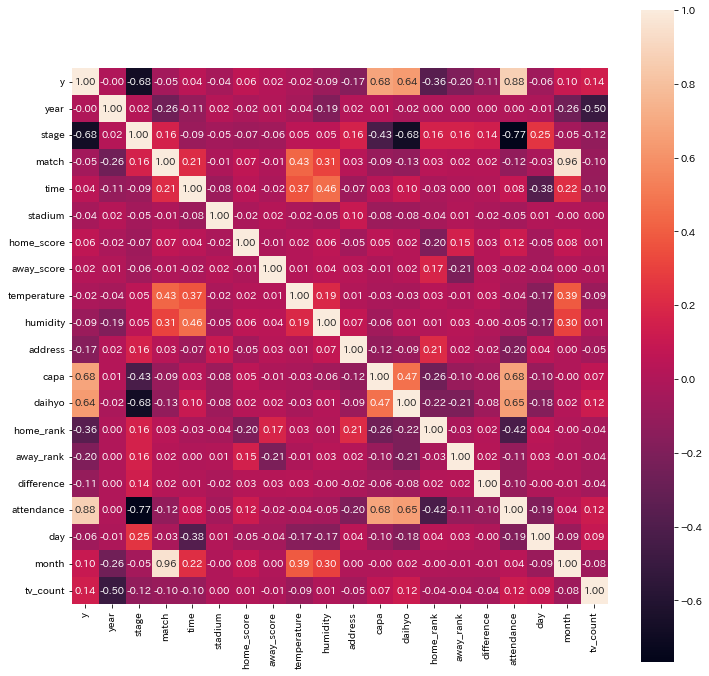

In [73]:
# ヒートマップの表示
plt.figure(figsize=(12, 12))
sns.heatmap(df_2.corr(), annot=True, square=True, fmt='.2f')
plt.show()

多重共線性の可能性？似ている変数を減らす or 統合  
①monthとmatch→両方削除しない  
②tv_countとtv→両方も削除  

できるだけ変数を減らす  
①humidity,temperature,weather→削除しない  
②home_score,away_score→削除しない  
③year→削除  
④day→day:平日(0),土日祝日(1)  
  
one-hotエンコーディングを利用してダミー変数化  
①stage→ダミー変数化しない  
②rank→J1とJ2にわける

In [74]:
#homeとawayそれぞれチームと順位を合わせたDataFrameを作る。
team_df = pd.read_csv('team_2.csv')
home_df = team_df.loc[:,["順位(J1)","順位(J2)","チーム","年","ステージ"]]
home_df.columns =["home_rank_j1","home_rank_j2","home","year","stage"]
away_df = team_df.loc[:,["順位(J1)","順位(J2)","チーム","年","ステージ"]]
away_df.columns =["away_rank_j1","away_rank_j2","away","year","stage"]
home_df = home_df.fillna(0)
away_df = away_df.fillna(0)
home_df.head()

,home_rank_j1,home_rank_j2,home,year,stage
0,1.0,0.0,ガンバ大阪,2014,Ｊ１
1,2.0,0.0,浦和レッズ,2014,Ｊ１
2,3.0,0.0,鹿島アントラーズ,2014,Ｊ１
3,4.0,0.0,柏レイソル,2014,Ｊ１
4,5.0,0.0,サガン鳥栖,2014,Ｊ１


In [79]:
def preprocessing_3(df):
    df_2 = df
    #名字と名前の間の空白をなくす
    for i in range(1,12):
        df_2["home_{:02}".format(i)] = df_2["home_{:02}".format(i)].apply(lambda x: x.replace("　",""))
        df_2["away_{:02}".format(i)] = df_2["away_{:02}".format(i)].apply(lambda x: x.replace("　",""))
    #home_01~11,away01~11→True,False
    for i in range(len(df_2)):
        for j in range(1,12):
            df_2.loc[i,"home_{:02}".format(j)] = df_2.loc[i,"home_{:02}".format(j)] in daihyo_list
            df_2.loc[i,"away_{:02}".format(j)] = df_2.loc[i,"away_{:02}".format(j)] in daihyo_list
    #daihyo
    df_2["daihyo"] = (df_2==True).sum(axis=1)
    #home_rank,away_rank
    df_2 = pd.merge(df_2,home_df,on=["home","year","stage"],how="left")
    df_2 = pd.merge(df_2,away_df,on=["away","year","stage"],how="left")
    #attendance
    df_2 = pd.merge(df_2,attendance_df,on=["home","year"],how="left")
    #year → そのまま
    #match → 第〇説かどうかのみ抜き出す
    df_2['match'] = df_2['match'].apply(lambda x: int(x[1:].rsplit('節', 1)[0]))
    #gameday → 月(month)と曜日(day)を抽出
    #       → 曜日(day)を平日(0),土日祝休(1)でマッピング
    df_2['day'] = df_2['gameday'].apply(lambda x: x[:-1].rsplit('(', 1)[-1])
    day_mapping = {'月':0, '火':0, '水':0, '木':0,'金':0,'土':1,'日':1}
    df_2['day'] = df_2['day'].map(day_mapping)
    df_2['day'] = df_2["day"].fillna(1)
    df_2['month'] = df_2['gameday'].apply(lambda x: int(x[:2]))
    #time → 〇時(hour)の部分だけ抽出
    df_2['time'] = df_2['time'].apply(lambda x: int(x.split(':', 1)[0]))
#     for i in range(len(df_2)):
#         if df_2.loc[i,'time'] < 17:
#             df_2.loc[i,'time'] = 0
#         else:
#             df_2.loc[i,'time'] = 1
    #tv → 'NHK総合'を含む(0),'NHK'を含む(1),'BS'を含む(2),その他(3)とする
    #   → tvの数も抽出(tv_count)
    for i in range(len(df_2)):
        if 'ＮＨＫ総合' in df_2.loc[i,'tv']:
            df_2.loc[i,'tv']=0
        elif 'ＮＨＫ' in df_2.loc[i,'tv']:
            df_2.loc[i,'tv']=1
        elif  'ＢＳ' in df_2.loc[i,'tv']:
            df_2.loc[i,'tv']=1
        else:
            df_2.loc[i,'tv']=2
    #weather → "雨"もしくは"雪"を含む(0),"晴"を含む(2),'屋内'を含む(3),その他(1)とする
    for i in range(len(df_2)):
        if '雨' in df_2.loc[i,'weather']:
            df_2.loc[i,'weather']=0
        elif '雪' in df_2.loc[i,'weather']:
            df_2.loc[i,'weather']=0
        elif  '晴' in df_2.loc[i,'weather']:
            df_2.loc[i,'weather']=2
        elif  '屋内' in df_2.loc[i,'weather']:
            df_2.loc[i,'weather']=3
        else:
            df_2.loc[i,'weather']=1
    #temperature → そのまま
    #humidity → 〇％のみ抽出
    df_2['humidity'] = df_2['humidity'].apply(lambda x: int(x[:-1].rsplit('%', 1)[-1]))
    #capa → そのまま
    #address → 都道府県でマッピング
    df_2['address'] = df_2['address'].apply(lambda x: x[:2])
#     #one-hotエンコーディング
#    df_2 = pd.get_dummies(df_2, columns=["stage"])
    #stadium,stage → マッピング
    for column in ['stage','stadium','address']:
        le = preprocessing.LabelEncoder()
        le.fit(df_2[column])
        df_2[column] = le.transform(df_2[column])
    #もう使わない変数、数値じゃない変数を削除
    df_2 = df_2.drop( ['id', 'gameday', 'home', 'away', 'referee', 'home_team', 'home_01', 'home_02', 'home_03', 'home_04',
       'home_05', 'home_06', 'home_07', 'home_08', 'home_09', 'home_10',
       'home_11','away_team', 'away_01', 'away_02', 'away_03', 'away_04', 'away_05',
       'away_06', 'away_07', 'away_08', 'away_09', 'away_10', 'away_11','tv'],axis=1)
    return(df_2)

In [80]:
df= pd.read_csv('data_all.csv')
df_3 = preprocessing_3(df)
df_3.head()

,y,year,stage,match,time,stadium,home_score,away_score,weather,temperature,...,address,capa,daihyo,home_rank_j1,home_rank_j2,away_rank_j1,away_rank_j2,attendance,day,month
0,18250,2012,0,1,14,15,1,0,0,3.8,...,8,19694,2,2.0,0.0,11.0,0.0,16600.0,1.0,3
1,24316,2012,0,1,14,48,1,0,3,12.4,...,17,40000,2,7.0,0.0,9.0,0.0,17155.0,1.0,3
2,17066,2012,0,1,14,17,2,3,0,11.3,...,7,21000,4,17.0,0.0,16.0,0.0,14778.0,1.0,3
3,29603,2012,0,1,14,3,1,0,0,11.4,...,14,50000,9,1.0,0.0,3.0,0.0,17721.0,1.0,3
4,25353,2012,0,1,14,36,0,0,3,22.5,...,3,39232,3,18.0,0.0,12.0,0.0,12008.0,1.0,3


In [81]:
#外れ値処理
for i in range(len(df_3)):
    if df_3.loc[i,'y'] == 0 or df_3.loc[i,'y'] >= 50000:
        df_3 = df_3.drop(i,axis=0)
        print(i)
df_3.index = np.arange(len(df_3))

270
693
942
1385
1463
1844


In [82]:
y = pd.DataFrame(df_3, columns=['y'])
x = df_3.drop('y',axis=1)
#標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_std = ss.fit_transform(x)

In [83]:
lasso(x_std,y)

[自由度調整済み決定係数]
1次
train: 0.765401
test : 0.768273
2次
train: 0.771
test : 0.768
3次
train: 0.773
test : 0.757

[RMSE]
1次
train: 3772.362
test : 3730.532
2次
train: 3722.411
test : 3729.844
3次
train: 3711.409
test : 3813.813


In [84]:
lgbm(x_std,y)

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1362, number of used features: 20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Start training from score 10524.246696
[1]	valid_0's rmse: 7133.45
[2]	valid_0's rmse: 6584.91
[3]	valid_0's rmse: 6123.25
[4]	valid_0's rmse: 5690.09
[5]	valid_0's rmse: 5334.76
[6]	valid_0's rmse: 5019.44
[7]	valid_0's rmse: 4760.61
[8]	valid_0's rmse: 4541.1
[9]	valid_0's rmse: 4359.27
[10]	valid_0's rmse: 4201.06
[11]	valid_0's rmse: 4061.99
[12]	valid_0's rmse: 3955.33
[13]	valid_0's rmse: 3848.78
[14]	valid_0's rmse: 3762.39
[15]	valid_0's rmse: 3679.17
[16]	valid_0's rmse: 3621.14
[17]	valid_0's rmse: 3565.86
[18]	valid_

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [85]:
test_df = pd.read_csv('test_new.csv')
test_df_3 = preprocessing_3(test_df)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_test_std = ss.fit_transform(test_df_3)

In [86]:
##Lasso提出(2次)
submit(model_lasso_1,test_df,x_test_std)

In [87]:
##LGBM提出(2次)
submit(model,test_df,x_test_std)